#### Merge Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

#File path
excel_file_path = 'Excel_files/Task_Data_Scientist_Dataset.xlsx'

# Make excel sheets into dataframes
df_sheet2 = pd.read_excel(excel_file_path, sheet_name='Soc_Dem')
df_sheet3 = pd.read_excel(excel_file_path, sheet_name='Products_ActBalance')
df_sheet4 = pd.read_excel(excel_file_path, sheet_name='Inflow_Outflow')
df_sheet5 = pd.read_excel(excel_file_path, sheet_name='Sales_Revenues')

# Merging the Dataframes based on the column 'Client'
df = pd.merge(df_sheet2, df_sheet3, on='Client', how='outer')
df = pd.merge(df, df_sheet4, on='Client', how='outer')

# Distinguish the full merged dataset and the individual one accounting for 60%
df_merge = pd.merge(df, df_sheet5, on='Client', how='outer')

display(df_merge.shape)
display(df_merge.head())

(1615, 36)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,909,M,21,27,1,NaN,NaN,1.0,NaN,1.0,...,7.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.893929,0.0
3,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,38.0,1.0,26.0,11.0,1.0,0.0,0.0,4.929643,0.000000,0.0
4,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [2]:
duplicate_rows = df_merge.duplicated().sum()

print('Total number of duplicate rows:',duplicate_rows)

Total number of duplicate rows: 0


In [3]:
# Create dummy variables for Sex
sex_mapping = {'M': 1, 'F': 0}
df_merge['Sex'] = df_merge['Sex'].replace(sex_mapping)

In [4]:
# Replace missing values with 0
df_merge = df_merge.replace(np.nan,0)

In [5]:
# Create Merged excel file

current_directory = os.getcwd()
output_folder_path = 'Excel_files'

# Generating a new excel file with the corresponding excel folder
output_excel_path = os.path.join(output_folder_path, 'Merged_dataset.xlsx')

df_merge.to_excel(output_excel_path, index=False)

#### Exploratory Data Analysis

##### Client Age

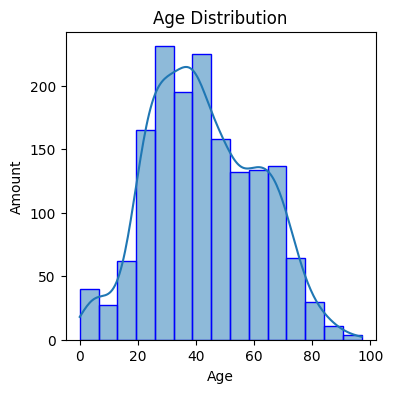

In [6]:
# Review the age distribution

plt.figure(figsize=(4, 4))

sns.histplot(df_merge['Age'], bins=15, edgecolor="b", kde=True)

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Amount')

plt.show()


There seem to be ages that are quite young for holding accounts at the bank. Hence, I can assume that these values are erroneous.
Here, I will verify how many clients are younger than 10 years old (min. age account opening in Belgium). 
Moreover, I will verify whether there are irregularities of 'Tenure' being larger than the actual age of a client as well.

In [7]:
# Verify the rows where Age is less than 10 years old

age_threshold = df_merge['Age'] < 10
print("Underage clients:", age_threshold.sum())

Underage clients: 51


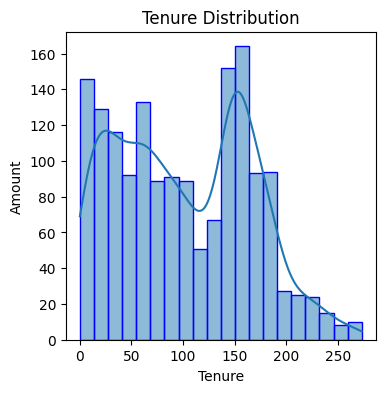

In [8]:
plt.figure(figsize=(4, 4))

sns.histplot(df_merge['Tenure'], bins=20, edgecolor="b", kde=True)

plt.title('Tenure Distribution')
plt.xlabel('Tenure')
plt.ylabel('Amount')

plt.show()

In [9]:
# Verify when Tenure in years is larger than Age

anomaly_tenure = df_merge['Tenure']/12 > df_merge['Age']

print("Number of Tenure anomalies:", anomaly_tenure.sum())

Number of Tenure anomalies: 47


##### Gender

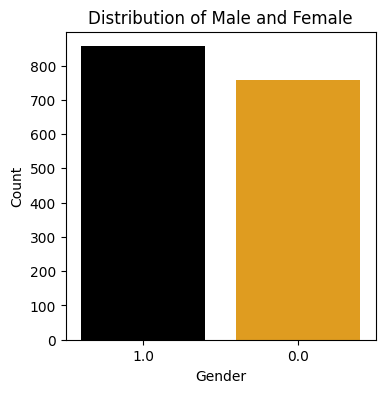

In [10]:
warnings.filterwarnings("ignore")

df_merge['Sex'] = df_merge['Sex'].astype(str)

plt.figure(figsize=(4, 4))


sns.countplot(x='Sex', data=df_merge, palette={'0.0': 'orange', '1.0': 'black'})

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Male and Female')
plt.show()

##### Sales Revenue

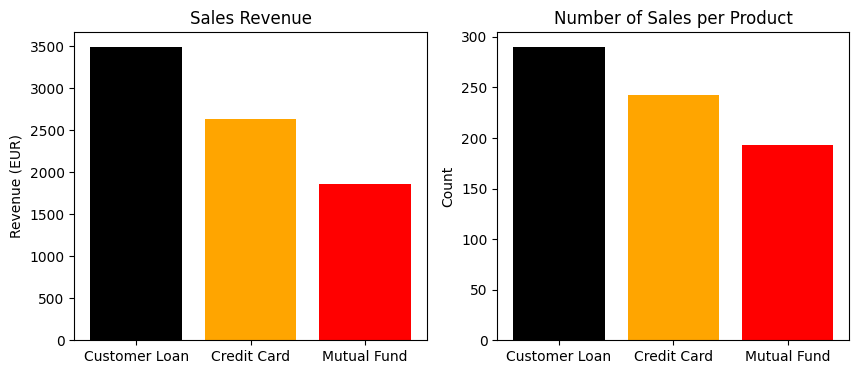

In [11]:

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Sales Revenue
columns_revenue = np.arange(3)
revenue = [df_merge['Revenue_CL'].sum(), df_merge['Revenue_CC'].sum(), df_merge['Revenue_MF'].sum()]

ax1.bar(columns_revenue, revenue, align='center', color=["black", "orange", "red"])
ax1.set_xticks(columns_revenue)
ax1.set_xticklabels(['Customer Loan', 'Credit Card', 'Mutual Fund'])
ax1.set_ylabel('Revenue (EUR)')
ax1.set_title('Sales Revenue')

# Number of Sales per Product
columns_sales = np.arange(3)
sales = [df_merge['Sale_CL'].sum(), df_merge['Sale_CC'].sum(), df_merge['Sale_MF'].sum()]

ax2.bar(columns_sales, sales, align='center', color=["black", "orange", "red"])
ax2.set_xticks(columns_sales)
ax2.set_xticklabels(['Customer Loan', 'Credit Card', 'Mutual Fund'])
ax2.set_ylabel('Count')
ax2.set_title('Number of Sales per Product')

plt.show()


#### Training Set Preparation

##### Merge Training Set

In [12]:
# 60% conveying training set, hence excluding df_merge
df_train = pd.merge(df, df_sheet5, on='Client', how='inner')

display(df_train.shape)
display(df_train.head())

(969, 36)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0,0,0,0.000000,0.000000,0.000000
1,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,0.0,1.0,0,1,0,0.000000,0.893929,0.000000
2,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,38.0,1.0,26.0,11.0,1,0,0,4.929643,0.000000,0.000000
3,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0.000000,0.000000,0.000000
4,225,M,14,187,1,NaN,NaN,1.0,NaN,NaN,...,5.0,0.0,4.0,1.0,0,0,1,0.000000,0.000000,8.130714


##### Gender

In [13]:
# Replace M/F with dummy variables
df_train['Sex'] = df_train['Sex'].replace(sex_mapping)

In [14]:
missing_value_sex= df_train['Sex'].isnull().sum()
display(missing_value_sex)

# Replace missing values with 0
df_train = df_train.replace(np.nan,0)

2

##### Age and Tenure

In [15]:
# Replacing ages younger than 10 with the mean

mean_age = df_train['Age'].mean()
df_train.loc[df_train['Age'] < 10, 'Age'] = mean_age

mean_tenure = df_train['Tenure'].mean()
df_train.loc[df_train['Tenure']/12 > df_train['Age'],'Tenure'] = int(mean_tenure)

In [16]:
# Verifying if Age and Tenure are making sense
age_threshold_train = df_train['Age'] < 10
print("Underage clients:", age_threshold_train.sum())

anomaly_tenure_train = df_train['Tenure']/12 > df_train['Age']
print("Number of Tenure anomalies:", anomaly_tenure_train.sum())

Underage clients: 0
Number of Tenure anomalies: 0


##### Types

In [17]:
df_train[df_train.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        969 non-null    int64  
 1   Sex                           969 non-null    float64
 2   Age                           969 non-null    float64
 3   Tenure                        969 non-null    int64  
 4   Count_CA                      969 non-null    int64  
 5   Count_SA                      969 non-null    float64
 6   Count_MF                      969 non-null    float64
 7   Count_OVD                     969 non-null    float64
 8   Count_CC                      969 non-null    float64
 9   Count_CL                      969 non-null    float64
 10  ActBal_CA                     969 non-null    float64
 11  ActBal_SA                     969 non-null    float64
 12  ActBal_MF                     969 non-null    float64
 13  ActBa

##### Missing Values

In [18]:
percent_missing = round(df_train.isnull().sum() * 100 / len(df),2)
missing_value_df = pd.DataFrame({'Missing_Percentage': percent_missing})
missing_value_df.sort_values(by="Missing_Percentage",ascending=False)

,Missing_Percentage
Client,0.0
Sex,0.0
VolumeDeb,0.0
VolumeDeb_CA,0.0
VolumeDebCash_Card,0.0
VolumeDebCashless_Card,0.0
VolumeDeb_PaymentOrder,0.0
TransactionsDeb,0.0
TransactionsDeb_CA,0.0
TransactionsDebCash_Card,0.0


#### Training Sets

##### Creation of Training Set

In [19]:
# Create full training set for consumer loan
consumer_loan = ['Sale_MF','Sale_CC','Revenue_MF','Revenue_CC','Count_CL','ActBal_CL']
df_train_cl = df_train.drop(consumer_loan,axis=1)

# Create full training set for credit card
credit_card = ['Sale_MF','Sale_CL','Revenue_MF','Revenue_CL','Count_CC','ActBal_CC']
df_train_cc  = df_train.drop(credit_card,axis=1)

# Create full training set for mutual fund
mutual_fund = ['Sale_CC','Sale_CL','Revenue_CC','Revenue_CL','Count_MF','ActBal_MF']
df_train_mf = df_train.drop(mutual_fund,axis=1)

In [20]:
print(df_train_cl.shape)
print(df_train_cc.shape)
print(df_train_mf.shape)

(969, 30)
(969, 30)
(969, 30)


In [21]:
df_train_cl.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,ActBal_CA,...,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CL,Revenue_CL
0,1217,1.0,38.0,165,1,0.0,0.0,0.0,0.0,6752.244643,...,0.000000,0.000000,714.285714,1.0,1.0,0.0,0.0,1.0,0,0.000000
1,850,0.0,49.0,44,1,0.0,0.0,0.0,0.0,43.523214,...,0.000000,0.000000,121.928571,6.0,6.0,0.0,0.0,1.0,0,0.000000
2,1473,1.0,54.0,34,1,1.0,0.0,0.0,1.0,29.024286,...,357.142857,444.597500,2076.785714,48.0,38.0,1.0,26.0,11.0,0,0.000000
3,1038,1.0,29.0,106,1,0.0,0.0,0.0,0.0,27.035714,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,225,1.0,14.0,100,1,0.0,0.0,1.0,0.0,345.686071,...,0.000000,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0,1,8.130714


##### Imbalance of Datasets

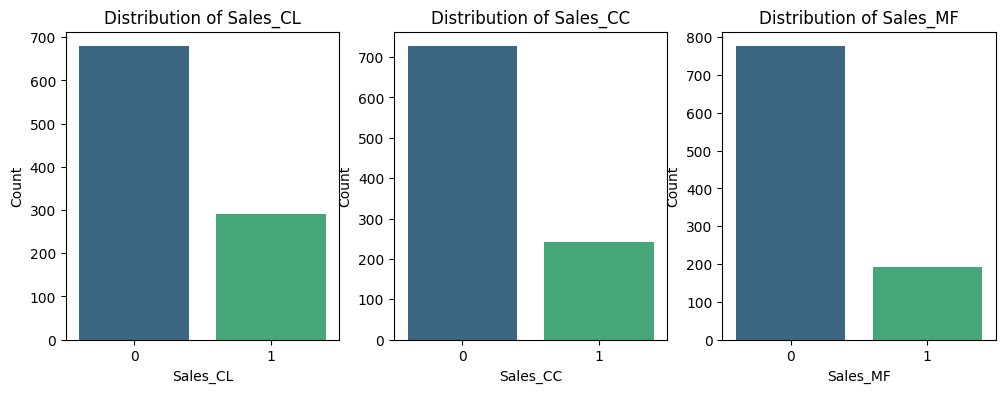

In [22]:
# Reviewing whether there is imbalance of the datasets

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Sale_CL
sns.countplot(x='Sale_CL', data=df_train_cl, palette='viridis', ax=ax1)
ax1.set_xlabel('Sales_CL')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Sales_CL')

# Sale_CC
sns.countplot(x='Sale_CC', data=df_train_cc, palette='viridis', ax=ax2)
ax2.set_xlabel('Sales_CC')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Sales_CC')

# Sale_MF
sns.countplot(x='Sale_MF', data=df_train_mf, palette='viridis', ax=ax3)
ax3.set_xlabel('Sales_MF')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Sales_MF')

plt.show()


As can be seen from the bar charts, there is indeed the scenario of an imbalanced dataset. Herein, I will use methods such as Random Forests and GradientBoosting which are more robust towards imbalanced datasets. Moreover, I will use performance metrics such as precision, recall, F1-score and AUC, which are more suitable for similar datasets

In [23]:
import os
import pickle

directory_path = 'Pickle_Files'

os.makedirs(directory_path, exist_ok=True)

file_path1 = 'Pickle_Files/Customer_Loan.pkl'
file_path2 = 'Pickle_Files/Credit_Card.pkl'
file_path3 = 'Pickle_Files/Mutual_Fund.pkl'

with open(file_path1, 'wb') as f1:
    pickle.dump(df_train_cl, f1)

with open(file_path2, 'wb') as f2:
    pickle.dump(df_train_cc, f2)

with open(file_path3, 'wb') as f3:
    pickle.dump(df_train_mf, f3)


In [24]:
df_train_cl.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,ActBal_CA,...,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CL,Revenue_CL
0,1217,1.0,38.0,165,1,0.0,0.0,0.0,0.0,6752.244643,...,0.000000,0.000000,714.285714,1.0,1.0,0.0,0.0,1.0,0,0.000000
1,850,0.0,49.0,44,1,0.0,0.0,0.0,0.0,43.523214,...,0.000000,0.000000,121.928571,6.0,6.0,0.0,0.0,1.0,0,0.000000
2,1473,1.0,54.0,34,1,1.0,0.0,0.0,1.0,29.024286,...,357.142857,444.597500,2076.785714,48.0,38.0,1.0,26.0,11.0,0,0.000000
3,1038,1.0,29.0,106,1,0.0,0.0,0.0,0.0,27.035714,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,225,1.0,14.0,100,1,0.0,0.0,1.0,0.0,345.686071,...,0.000000,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0,1,8.130714
